<a id='section_id0'></a>
***

# Data Programming Essentials *with Python*


## Prediction Approaches: Model Tuning

***
Topics in this Notebook:

* [Topic 1: Tuning linear regression prediction model](#section_id1)<br>
* [Topic 2: Tuning logistic regression prediction model](#section_id2)<br>
* [Topic 3: Tuning KNN prediction model](#section_id3)<br>
* [Topic 4: Tuning tree-based prediction models](#section_id4)<br>
***

***
### Summary of steps in our prediction workflow:
1. Clean and pre-process data
2. Explore patterns in data
  * Identify options for investigations / story lines / narratives
  * Are you interested in explaining or predicting or both?
  * Is your dependent variable (predicted/response) continuous (regression problem) or categorical (classification problem)?
3. Train the models
  * Linear regression
  * Logistic regression
  * KNN
  * Naive Bayes
  * Tree-based approaches: Bagging, RandomForest, and Boosting
  * <span style="background-color:Gold">Advanced: Utilize GridSearchCV for model tuning (which is the topic of this notebook)</span>
4. Evaluate models through k-fold cross-validation
  * Regression problem metric: RMSE derived by comparing predicted values with actuals
  * Classification problem metric: Accuracy derived from the confusion matrix
***   
### Reference
* Our go to library for prediction is SciKit-Learn. [A comprehensive guide](https://scikit-learn.org/stable/user_guide.html) for SciKit-Learn is available.
* The GridSearchCV and other methods for [model tuning is documented here](https://scikit-learn.org/stable/modules/grid_search.html)
***

Preliminaries: loading libraries and reading the datasets into memory

In [1]:
import pandas as pd
import numpy as np
import scipy as sp

In [2]:
# for regressions:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import sklearn.linear_model as sklm

# for KNN:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor

#for model evaluation and pre-processing tools:
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import confusion_matrix, classification_report, precision_score, \
                            accuracy_score, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score

#for modeling with decision trees:
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, BaggingRegressor, \
    RandomForestRegressor, GradientBoostingRegressor, GradientBoostingClassifier

#for model tuning:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline

#for plotting confusion matrix:
import scikitplot as skplt

#for plotting decision trees
import pydotplus as pplus
import graphviz
from IPython.display import Image
from six import StringIO

#dmba stuff
from dmba import regressionSummary, exhaustive_search
from dmba import adjusted_r2_score, AIC_score, BIC_score
from dmba import classificationSummary, gainsChart, liftChart, plotDecisionTree

no display found. Using non-interactive Agg backend


In [3]:
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2,'font.family': [u'times']})
import matplotlib.pylab as plt
%matplotlib inline 
plt.style.use('seaborn-whitegrid')
plt.rc('text', usetex = False)
plt.rc('font', family = 'serif')
plt.rc('xtick', labelsize = 10) 
plt.rc('ytick', labelsize = 10) 
plt.rc('font', size = 12) 
plt.rc('figure', figsize = (12, 5))

In [4]:
# sometimes, the following is also needed to get the visualization to work
# Here, we get the path variable of the graphviz package installed in your machine.
import os
os.environ['PATH'] = os.environ['PATH']+';'+os.environ['CONDA_PREFIX']+r"\Library\bin\graphviz"

We use the function in the cell below for visualizing the decision trees:

In [5]:
#This function helps with drawing decision trees using the pydotplus and graphviz libraries
def print_tree(estimator, features, class_names=None, filled=True):
    tree = estimator
    names = features
    color = filled
    classn = class_names
    
    dot_data = StringIO()
    export_graphviz(estimator, out_file=dot_data, feature_names=features, class_names=classn, filled=filled)
    graph = pplus.graph_from_dot_data(dot_data.getvalue())
    return(graph)

As usual, we'll read datasets using Pandas, even though Scikit doesn't natively work with Pandas data structures.

In [6]:
df1 = pd.read_csv('sleeping.csv')

|Variable|Description|
|:------|:------|
|sleeping|sleep hours on an average shcool night: 1=<4 hrs, 2=5 hrs, 3=6 hrs, 4=7 hrs, 5=8 hrs, 6=9 hrs, 7= >=10 hrs|
|sex|1=Female, 2=Male|
|race|1=White, 2=Black or African American, 3=Hispanic/Latino, 4=All other races|
|sexharass|sexual harassment during the past 12 months: 1=0 times, 2=1 time, 3=2 or 3 times, 4=4 or 5 times, 5=6 or more times|
|smoking|smoke cigarettes during the past 30 days: 1=0 days, 2=1 or 2 days, 3=3 to 5 days, 4= 6 to 9 days, 5=10 to 19 days, 6=20 to 29 days, 7=all 30 days|
|vegetables|eating other vegetables(do not count green salad, potatoes, or carrots) during the past 7 days: 1=0 times, 2=1 to 3 times, 3=4 to 6 times, 4=1 time/day, 5=2 times/day, 6=3 times/day, 7=>= 4 times/day|
|soda|drinking soda or pop during past 7 days: 1= 0 times, 2=1 to 3 times, 3=4 to 6 times, 4=1 time/day, 5=2 times/day, 6=3 times/day, 7=>=4 times/day |
|breakfast|days of eating breakfast per week: 1=0 day, 2=1 day, 3=2 days, 4=3 days, 5= 4 days, 6=5 days, 7=6 days, 8= 7 days|
|computer|hours of playing computer games or something that is not school work per day: 1=0 hrs, 2=<1 hr, 3=1 hr, 4=2 hrs, 5=3 hrs, 6=4 hrs, 7=>=5 hrs|

***
<Mark>Navigation:</Mark><br>
* [Topic 1: Tuning linear regression prediction model](#section_id1)<br>
* [Topic 2: Tuning logistic regression prediction model](#section_id2)<br>
* [Topic 3: Tuning KNN prediction model](#section_id3)<br>
* [Topic 4: Tuning tree-based prediction models](#section_id4)<br>
***

<div style="text-align: right"> <a href='#section_id0'>Back to top of Notebook</a></div>

<a id='section_id1'></a>
### <span style="background-color:#B0E0E6">Topic 1: Tuning linear regression models (e.g., polynomials, interactions)</span>

In [7]:
# First, define the X (predictor/independent) and the Y (predicted/dependent) variables:
# SciKit doesn't work with Pandas dataframes, so we just need the matrix of values in the dataframe.

X=df1[['sex', 'race', 'sexharass', 'smoking', 'vegetables', 'soda', 'breakfast', 'computer']].values
Y=df1.sleeping

In [10]:
# Second, split the data into training and test portions:
# I am using 25% of data for testing and 75% for training.

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=7)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(27165, 8) (27165,)
(9055, 8) (9055,)


#### Getting Polynomial features

SciKit [documentation on polynomial features](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html)

In [11]:
poly_features = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)

In [12]:
X_poly = poly_features.fit_transform(X)

In [13]:
X[1]

array([2, 3, 1, 1, 2, 1, 1, 2], dtype=int64)

In [14]:
X_poly[1] #includes the 

array([2., 3., 1., 1., 2., 1., 1., 2., 4., 6., 2., 2., 4., 2., 2., 4., 9.,
       3., 3., 6., 3., 3., 6., 1., 1., 2., 1., 1., 2., 1., 2., 1., 1., 2.,
       4., 2., 2., 4., 1., 1., 2., 1., 2., 4.])

If you need only the interaction variables, use the "interaction_only" parameter:

In [15]:
poly_features_int = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)

In [16]:
X_poly_int=poly_features_int.fit_transform(X)

In [17]:
X_poly_int[1]

array([2., 3., 1., 1., 2., 1., 1., 2., 6., 2., 2., 4., 2., 2., 4., 3., 3.,
       6., 3., 3., 6., 1., 2., 1., 1., 2., 2., 1., 1., 2., 2., 2., 4., 1.,
       2., 2.])

#### Grid search on polynomial regression: which order polynomial gets good predictions?

In [19]:
#define the polynomial regression using the pipeline function in preprocessing:

def PolyReg(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree), sklm.LinearRegression(**kwargs))

In [20]:
# set the gridsearch parameter: search from degrees 0 through 7:

param_grid={'polynomialfeatures__degree': np.arange(7)}

In [21]:
# define the gridsearch:

poly_grid = GridSearchCV(PolyReg(), param_grid, cv=5, scoring='neg_mean_squared_error')

In [22]:
#fit the gridsearch:

poly_grid.fit(X_train, Y_train)

C:\Users\edwar\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: could not broadcast input array from shape (21732,8) into shape (21732,0)

  FitFailedWarning)
C:\Users\edwar\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: could not broadcast input array from shape (21732,8) into shape (21732,0)

  FitFailedWarning)
C:\Users\edwar\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: could not broadcast input array from shape (21732,8) into shape (21732,0)

  FitFailedWarning)
C:\Users\edwar\anaconda3\lib

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('polynomialfeatures',
                                        PolynomialFeatures(degree=2,
                                                           include_bias=True,
                                                           interaction_only=False,
                                                           order='C')),
                                       ('linearregression',
                                        LinearRegression(copy_X=True,
                                                         fit_intercept=True,
                                                         n_jobs=None,
                                                         normalize=False))],
                                verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'polynomialfeatures__degree': array([0, 1, 2, 3, 4, 5, 6])},
             pre_dispat

In [23]:
#get the cross validation results from the gridsearch:

poly_grid.cv_results_

{'mean_fit_time': array([1.33985043e-02, 6.05914593e-02, 8.85229588e-02, 3.29734468e-01,
        1.14007540e+00, 4.22153010e+00, 2.51838248e+01]),
 'std_fit_time': array([0.00134956, 0.06080629, 0.00849692, 0.01980137, 0.1499019 ,
        0.26504886, 0.70166306]),
 'mean_score_time': array([0.        , 0.00362287, 0.00652437, 0.02678595, 0.05832515,
        0.13453012, 0.28013344]),
 'std_score_time': array([0.        , 0.00205885, 0.00242382, 0.00538645, 0.00848884,
        0.00780172, 0.00352711]),
 'param_polynomialfeatures__degree': masked_array(data=[0, 1, 2, 3, 4, 5, 6],
              mask=[False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'polynomialfeatures__degree': 0},
  {'polynomialfeatures__degree': 1},
  {'polynomialfeatures__degree': 2},
  {'polynomialfeatures__degree': 3},
  {'polynomialfeatures__degree': 4},
  {'polynomialfeatures__degree': 5},
  {'polynomialfeatures__degree': 6}],
 'split0_test_score': ar

In [24]:
#Mean negative-MSE scores across the different runs of the CV:
poly_grid.cv_results_['mean_test_score']

array([            nan, -1.78794669e+00, -1.77482318e+00, -1.77624635e+00,
       -1.80522859e+00, -2.15888718e+00, -1.54156063e+11])

In [25]:
#which degree gave the best results?

poly_grid.best_params_

{'polynomialfeatures__degree': 2}

In [26]:
#which is the best parameter?

poly_grid.best_estimator_

Pipeline(memory=None,
         steps=[('polynomialfeatures',
                 PolynomialFeatures(degree=2, include_bias=True,
                                    interaction_only=False, order='C')),
                ('linearregression',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

In [27]:
#getting the coefficients from the best estimator: 

poly_grid.best_estimator_.steps[1][1].intercept_

3.5010595255561503

In [28]:
poly_grid.best_estimator_.steps[1][1].coef_

array([-4.88481871e-17, -1.25385341e-04, -3.89706908e-01, -5.50116090e-01,
       -6.45088343e-02,  1.07712473e-02,  7.45593634e-02,  1.51301313e-01,
        1.57394997e-01, -3.76156022e-04, -1.82693535e-02, -4.50039513e-03,
       -5.19706855e-02,  3.27417560e-02,  7.73807153e-03,  1.71052484e-02,
        1.71006399e-03,  5.56328693e-02,  6.63943390e-03,  7.44715705e-03,
        9.60300719e-03,  1.60177634e-02, -3.13093790e-04,  1.30687995e-03,
        5.58267606e-02, -4.73872295e-03,  1.04306116e-02, -4.25356223e-03,
        1.46290828e-02,  1.50935440e-02,  1.77294337e-03,  2.45167496e-03,
        6.93659867e-03, -2.62338981e-03,  2.83504945e-03, -3.68904935e-03,
       -4.29995066e-03, -3.72025423e-03, -8.75862009e-03, -1.34111828e-02,
       -4.94669891e-03, -4.61085345e-03, -8.16521306e-04, -8.96016133e-03,
       -1.80177147e-02])

In [29]:
#get the predictions from the best estimator for the test sample:

poly_predictions_tt=poly_grid.best_estimator_.predict(X_test)

In [30]:
# How good is the prediction for the test sample?

np.sqrt(np.square(poly_predictions_tt-Y_test).mean())

1.327636433826819

<Mark>Interpretation:</Mark> Suppose, sleeping duration is measured in hours, our prediction using the second order polynomial with interaction effects is deviant from the actual values by about 1.3 hours, on average, for the test sample.<br> 
Looking at the spread of sales (see boxplot below), which is in the range of 8 hours per shool night, the prediction does seem pretty good.

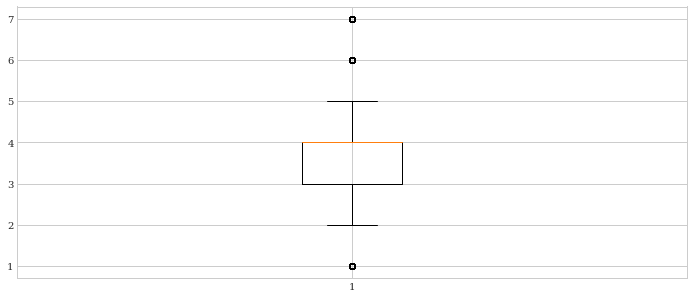

In [31]:
fig=plt.boxplot(Y_test)

***
<Mark>Navigation:</Mark><br>
* [Topic 1: Tuning linear regression prediction model](#section_id1)<br>
* [Topic 2: Tuning logistic regression prediction model](#section_id2)<br>
* [Topic 3: Tuning KNN prediction model](#section_id3)<br>
* [Topic 4: Tuning tree-based prediction models](#section_id4)<br>
***

<div style="text-align: right"> <a href='#section_id0'>Back to top of Notebook</a></div>

<a id='section_id2'></a>
### <span style="background-color:#B0E0E6">Topic 2: Tuning the logistic regression model</span>

In [33]:
df1.columns


Index(['sleeping', 'sex', 'race', 'sexharass', 'smoking', 'vegetables', 'soda',
       'breakfast', 'computer'],
      dtype='object')

In [34]:
# inserting a health_category column
df1['sleepcat']=pd.cut(df1['sleeping'], bins=[0,4,8], labels=['short', 'long']) # 0 = short, 1 =long
df1.head(6)

,sleeping,sex,race,sexharass,smoking,vegetables,soda,breakfast,computer,sleepcat
0,1,2,4,4,4,3,2,3,3,short
1,1,2,3,1,1,2,1,1,2,short
2,1,2,4,1,1,1,1,1,1,short
3,3,2,4,1,1,3,5,5,4,short
4,3,2,4,1,6,2,6,5,7,short
5,5,2,4,1,1,5,2,4,5,long


In [35]:
healthdummy=pd.get_dummies(df1['sleepcat'])
df1['sleepcatlong']=healthdummy['long']
yvar= df1.sleepcatlong.astype('float64')
Xvar = df1.drop(['sleeping', 'sleepcat','sleepcatlong'], axis=1).astype('float64')

In [36]:
# Second, split the data into training and test portions:

X2_train, X2_test, Y2_train, Y2_test = train_test_split(Xvar, yvar, test_size=0.25, random_state=7)
print(X2_train.shape, Y2_train.shape)
print(X2_test.shape, Y2_test.shape)

(27165, 8) (27165,)
(9055, 8) (9055,)


Refer to the [documentation of the LogisticRegression in SciKit](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) to learn about the many parameters available for tuning the underlying optimization procedures.
* For illustration, we can tweak the penaly (l1 or l2) and a regularization parameter called as *C*.

In [37]:
insurancereg=sklm.LogisticRegression(solver='liblinear')

In [38]:
# set the gridsearch parameters for logistic regression
lg_param_grid={'penalty': ['l1', 'l2'], 'C': np.logspace(0,2,10)}

In [39]:
# define the gridsearch for logistic regression:

lg_grid = GridSearchCV(insurancereg, lg_param_grid, cv=5, scoring='accuracy')

In [40]:
#fit the gridsearch:

lg_grid.fit(X2_train, Y2_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='liblinear',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([  1.        ,   1.66810054,   2.7825594 ,   4.64158883,
         7.74263683,  12.91549665,  21.5443469 ,  35.93813664,
        59.94842503, 100.        ]),
                         'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accura

In [41]:
#get the cross validation results from the gridsearch (be patient!)

lg_grid.cv_results_['mean_test_score']

array([0.75085588, 0.75085588, 0.75085588, 0.75085588, 0.75085588,
       0.75085588, 0.75085588, 0.75085588, 0.75085588, 0.75085588,
       0.75085588, 0.75085588, 0.75085588, 0.75085588, 0.75085588,
       0.75085588, 0.75085588, 0.75085588, 0.75085588, 0.75085588])

In [42]:
#which parameters give the best results?

lg_grid.best_params_

{'C': 1.0, 'penalty': 'l1'}

In [43]:
#which is the best estimator, according to the grid search?

lg_grid.best_estimator_

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [44]:
#getting the intercept/coefficients from the best estimator: 

lg_grid.best_estimator_.intercept_

array([-1.67614148])

In [45]:
#getting the intercept/coefficients from the best estimator: 
lg_grid.best_estimator_.coef_

array([[ 0.22573233, -0.06427415, -0.09097671, -0.10811719,  0.02627501,
        -0.01859039,  0.15956341, -0.07371347]])

In [46]:
features=df1.drop(['sleeping', 'sleepcat','sleepcatlong'], axis=1).columns
#these are the columns of independent variables in the caravan dataset.
features

Index(['sex', 'race', 'sexharass', 'smoking', 'vegetables', 'soda',
       'breakfast', 'computer'],
      dtype='object')

In [47]:
pd.set_option("display.max_rows", None)
pd.DataFrame({'Variable': features, 'Coefficients':lg_grid.best_estimator_.coef_[0]})

,Variable,Coefficients
0,sex,0.225732
1,race,-0.064274
2,sexharass,-0.090977
3,smoking,-0.108117
4,vegetables,0.026275
5,soda,-0.018590
6,breakfast,0.159563
7,computer,-0.073713


In [48]:
#get the predictions from the best estimator for the test sample:

lg_predictions_tt=lg_grid.best_estimator_.predict(X2_test)

In [49]:
# How good is the prediction for the test sample?

print("Classification Report:\n",classification_report(Y2_test, lg_predictions_tt))

Classification Report:
               precision    recall  f1-score   support

         0.0       0.75      1.00      0.86      6835
         1.0       0.00      0.00      0.00      2220

    accuracy                           0.75      9055
   macro avg       0.38      0.50      0.43      9055
weighted avg       0.57      0.75      0.65      9055



C:\Users\edwar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


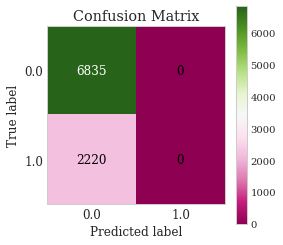

In [50]:
skplt.metrics.plot_confusion_matrix(Y2_test, lg_predictions_tt, figsize=(4,4), cmap="PiYG")

<Mark>Interpretation:</Mark> The best predictor from the gridsearch is almost like the naive predictor, where it says nobody will have sufficient sleep. 

***
<Mark>Navigation:</Mark><br>
* [Topic 1: Tuning linear regression prediction model](#section_id1)<br>
* [Topic 2: Tuning logistic regression prediction model](#section_id2)<br>
* [Topic 3: Tuning KNN prediction model](#section_id3)<br>
* [Topic 4: Tuning tree-based prediction models](#section_id4)<br>
***

<div style="text-align: right"> <a href='#section_id0'>Back to top of Notebook</a></div>

<a id='section_id3'></a>
### <span style="background-color:#B0E0E6">Topic 3: Tuning the KNN model</span>

* Nearest Neighbors is a non-parametric approach and can be used for both continuous outcomes (regression) and categorical outcomes (classification).
* [SciKit's documentation on Nearest Neighbors](https://scikit-learn.org/stable/modules/neighbors.html) is very detailed and shows many parameters than can be used.

In [6]:
df1 = pd.read_csv('sleeping.csv')

In [7]:
# First, scale the predictors and predicted variables:
Xp=preprocessing.scale(df1[['sex', 'race', 'sexharass', 'smoking', 'vegetables', 'soda', 'breakfast',
                            'computer']]).astype('float64')
Yp=preprocessing.scale(df1.sleeping).astype('float64')#scaling


In [8]:
# Set aside a portion (e.g., 25%) of data for out-of-training-sample testing.

X3p_train, X3p_test, Y3p_train, Y3p_test = train_test_split(Xp, Yp, \
                                                            test_size=0.25, random_state=7)
print(X3p_train.shape, Y3p_train.shape)
print(X3p_test.shape, Y3p_test.shape)

(27165, 8) (27165,)
(9055, 8) (9055,)


In [9]:
# Define the KNN model
knn_rcv = KNeighborsRegressor()

In [10]:
#set the parameters for KNN gridsearch
knn_param_grid = {'n_neighbors': np.arange(1,20), 'weights':['uniform', 'distance']}

In [11]:
# set up the grid search with KNN
knn_grid_search = GridSearchCV(KNeighborsRegressor(), knn_param_grid, cv=5, scoring = 'neg_mean_squared_error')

In [12]:
# fit the KNN model using training sample
knn_grid_search.fit(X3p_train, Y3p_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                           metric='minkowski',
                                           metric_params=None, n_jobs=None,
                                           n_neighbors=5, p=2,
                                           weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19]),
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [13]:
#get the cross validation results from the gridsearch:

knn_grid_search.cv_results_['mean_test_score']

array([-1.77757267, -1.77757267, -1.33616558, -1.39341788, -1.18253837,
       -1.27030778, -1.10953809, -1.22002462, -1.06276808, -1.19011406,
       -1.03773876, -1.17589744, -1.01345678, -1.1631699 , -1.00053504,
       -1.15712155, -0.98517265, -1.14880773, -0.97754515, -1.14646075,
       -0.97145536, -1.14323641, -0.96489248, -1.14040286, -0.96080764,
       -1.13850207, -0.95671549, -1.13642735, -0.95121078, -1.1338457 ,
       -0.94726042, -1.1321107 , -0.94367309, -1.1304877 , -0.94153636,
       -1.12883493, -0.93954413, -1.12796897])

In [14]:
#which parameters gave the best results?

knn_grid_search.best_params_

{'n_neighbors': 19, 'weights': 'uniform'}

In [15]:
#which is the best estimator?

knn_grid_search.best_estimator_

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=19, p=2,
                    weights='uniform')

In [16]:
# how does the model perform in predicting?

knn_prediction_reg=knn_grid_search.best_estimator_.predict(X3p_test) #get the predictions using training data

In [17]:
np.sqrt(np.square(knn_prediction_reg-Y3p_test)).mean() #average error of prediction in training data.

0.7779760210499388

In [18]:
#to rescale the predicted values, we need to first fit the original scaler:
data = df1.sleeping.values
scaler = preprocessing.StandardScaler()
scaler.fit(data.reshape(-1, 1)) #reshaping is needed for 1-dimensional arrays
scaled = scaler.transform(data.reshape(-1, 1))
# for inverse transformation
inversedpredictions = scaler.inverse_transform(knn_prediction_reg)

In [19]:
regressionSummary(Y3p_test,inversedpredictions)


Regression statistics

                      Mean Error (ME) : -3.5204
       Root Mean Squared Error (RMSE) : 3.6600
            Mean Absolute Error (MAE) : 3.5211
          Mean Percentage Error (MPE) : 18.2533
Mean Absolute Percentage Error (MAPE) : 644.3666


<Mark>Interpretation:</Mark> We see that the KNN model from the grid search give a prediction that only deviant by about 0.78 hours per school night, on average, 

#### KNN Classification way:

In [63]:
df1.columns


Index(['sleeping', 'sex', 'race', 'sexharass', 'smoking', 'vegetables', 'soda',
       'breakfast', 'computer'],
      dtype='object')

In [64]:
df1['sleepcat']=pd.cut(df1['sleeping'], bins=[0,4,8], labels=['short', 'long']) # 0 = short, 1 =long
df1.head(6)

,sleeping,sex,race,sexharass,smoking,vegetables,soda,breakfast,computer,sleepcat
0,1,2,4,4,4,3,2,3,3,short
1,1,2,3,1,1,2,1,1,2,short
2,1,2,4,1,1,1,1,1,1,short
3,3,2,4,1,1,3,5,5,4,short
4,3,2,4,1,6,2,6,5,7,short
5,5,2,4,1,1,5,2,4,5,long


In [65]:
# pre-processing the data to get dummy for dependent variable
healthdummy=pd.get_dummies(df1['sleepcat'])
 #one dummy variable is sufficient for predictor with 2-levels
df1['sleeplong']=healthdummy['long']

In [66]:
yvar= df1.sleeplong.astype('float64')
 #just retain the independent variables
Xvar = df1.drop(['sleeping', 'sleeplong', 'sleepcat'], axis=1).astype('float64')

In [67]:
# we scale the Xvar before using KNN:
Xvarpc=preprocessing.scale(Xvar)

# y-variable is just 1 or 0 in the classification setting, so no need for scaling the predicted variable.

In [68]:
# Set aside 25% of data for out-of-training-sample test:

X3pc_train, X3pc_test, Y3pc_train, Y3pc_test = train_test_split(Xvarpc, yvar, \
                                                            test_size=0.25, random_state=7)
print(X3pc_train.shape, Y3pc_train.shape)
print(X3pc_test.shape, Y3pc_test.shape)

(27165, 8) (27165,)
(9055, 8) (9055,)


In [69]:
#set the parameters for KNN gridsearch
knn_param_grid = {'n_neighbors': np.arange(1,20), 'weights':['uniform', 'distance']}

In [70]:
# set up the grid search with KNN
knnc_grid_search = GridSearchCV(KNeighborsClassifier(), knn_param_grid, cv=5, scoring = 'accuracy')

In [71]:
# fit the KNN model using training sample
knnc_grid_search.fit(X3pc_train, Y3pc_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19]),
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [72]:
#get the cross validation results from the gridsearch:

knnc_grid_search.cv_results_['mean_test_score']

array([0.64811338, 0.64811338, 0.72523468, 0.69854592, 0.68580895,
       0.68308485, 0.7286582 , 0.70712314, 0.70892693, 0.70053378,
       0.73502669, 0.71183508, 0.72203203, 0.707933  , 0.73712498,
       0.71466961, 0.7283637 , 0.71297626, 0.73970182, 0.71621572,
       0.73248666, 0.71566354, 0.74172649, 0.71732008, 0.73705135,
       0.7170624 , 0.74198417, 0.71695196, 0.73716179, 0.71621572,
       0.74242592, 0.71750414, 0.73970182, 0.71610528, 0.74356709,
       0.71728327, 0.74080618, 0.71746733])

In [73]:
#which parameters gave the best results?

knnc_grid_search.best_params_

{'n_neighbors': 18, 'weights': 'uniform'}

In [74]:
#which is the best KNN estimator?

knnc_grid_search.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=18, p=2,
                     weights='uniform')

In [75]:
# how does the model perform in predicting?

knnc_prediction_clf=knnc_grid_search.best_estimator_.predict(X3pc_test) #get the predictions using test data

In [76]:
# Evaluate how good the knn classification is:
cm_knn = confusion_matrix(Y3pc_test, knnc_prediction_clf)
print("Confusion Matrix:\n", cm_knn)
print("\n")
print("Classification Report:\n",classification_report(Y3pc_test, knnc_prediction_clf))

Confusion Matrix:
 [[6590  245]
 [2093  127]]


Classification Report:
               precision    recall  f1-score   support

         0.0       0.76      0.96      0.85      6835
         1.0       0.34      0.06      0.10      2220

    accuracy                           0.74      9055
   macro avg       0.55      0.51      0.47      9055
weighted avg       0.66      0.74      0.67      9055



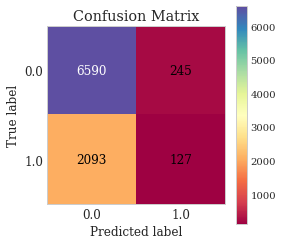

In [77]:
skplt.metrics.plot_confusion_matrix(Y3pc_test, knnc_prediction_clf, figsize=(4,4), cmap="Spectral")

<Mark>Interpretation:</Mark> We see that the model resulted in 74% accuracy of classifying sleep duration. 127 people who were sleep sufficiently were correctly identified by the model.It missed 2093 people and wrongly predicted 245 others having sufficient sleep.

***
<Mark>Navigation:</Mark><br>
* [Topic 1: Tuning linear regression prediction model](#section_id1)<br>
* [Topic 2: Tuning logistic regression prediction model](#section_id2)<br>
* [Topic 3: Tuning KNN prediction model](#section_id3)<br>
* [Topic 4: Tuning tree-based prediction models](#section_id4)<br>
***

<div style="text-align: right"> <a href='#section_id0'>Back to top of Notebook</a></div>

<a id='section_id4'></a>
### <span style="background-color:#B0E0E6">Topic 4: Tuning the Tree-Based Models</span>

* Using Decision Trees is another non-parametric approach, and it can be applied for both continuous outcomes (regression) and categorical outcomes (classification).
* [SciKit's documentation on Decision Trees](https://scikit-learn.org/stable/modules/tree.html) is very detailed and shows many parameters than can be used.

### Regression method

In [8]:
df1 = pd.read_csv('sleeping.csv')

In [80]:
# First, define the X (predictor/independent) and the Y (predicted/dependent) variables:
# SciKit doesn't work with Pandas dataframes, so we just need the matrix of values in the dataframe.

X=df1[['sex', 'race', 'sexharass', 'smoking', 'vegetables', 'soda', 'breakfast', 'computer']].values
Y=df1.sleeping

In [81]:
# Second, split the data into training and test portions:
# I am using 25% of data for testing and 75% for training.

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=7)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(27165, 8) (27165,)
(9055, 8) (9055,)


In [82]:
DTsalesreg=DecisionTreeRegressor(random_state=23)

In [83]:
# set the gridsearch parameters for the decision tree regression
dtr_param_grid={'max_depth':[3,5,7,10], 'max_leaf_nodes':np.arange(2,10)}

In [84]:
# define the gridsearch for the decision tree regression:

dtr_grid_search = GridSearchCV(DTsalesreg, dtr_param_grid, cv=5, scoring='neg_mean_squared_error')

In [85]:
# Fit the model on training data
# Since we are using the training portion of the data, we are now "training" our model.
dtr_grid_search.fit(X_train, Y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                             max_depth=None, max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort='deprecated',
                                             random_state=23, splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': [3, 5, 7, 10],
                         'max_leaf_nodes': array([2, 3, 4, 5, 6, 7, 8, 9])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=Fal

In [86]:
dtr_grid_search.cv_results_['mean_test_score']

array([-1.85988613, -1.83710918, -1.82818715, -1.8205748 , -1.8131281 ,
       -1.81098471, -1.80885766, -1.80885766, -1.85988613, -1.83710918,
       -1.82818715, -1.8205748 , -1.8131281 , -1.8105644 , -1.80668869,
       -1.80319403, -1.85988613, -1.83710918, -1.82818715, -1.8205748 ,
       -1.8131281 , -1.8105644 , -1.80668869, -1.80022192, -1.85988613,
       -1.83710918, -1.82818715, -1.8205748 , -1.8131281 , -1.8105644 ,
       -1.80668869, -1.80022192])

In [87]:
dtr_grid_search.best_params_

{'max_depth': 7, 'max_leaf_nodes': 9}

In [88]:
dtr_grid_search.best_estimator_

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=7,
                      max_features=None, max_leaf_nodes=9,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=23, splitter='best')

We can visualize the Decision Tree from the best_estimator_ as following:

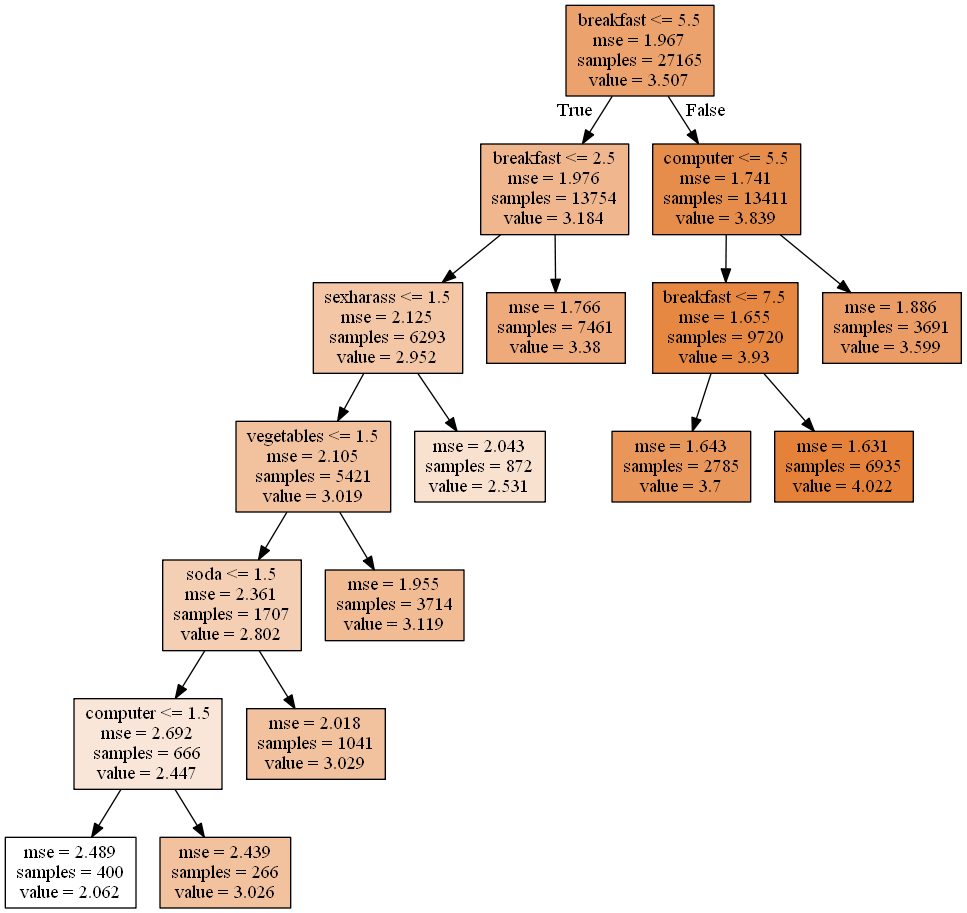

In [91]:
DTRgraph = print_tree(dtr_grid_search.best_estimator_, features=['sex', 'race', 'sexharass', 'smoking', 'vegetables', 'soda', 'breakfast', 'computer'])
Image(DTRgraph.create_png())

In [92]:
# Get the predicted values and evaluate the model:

DT_predictions_tr=dtr_grid_search.best_estimator_.predict(X_test) # predictions for test set

In [93]:
# How good is this prediction?

np.sqrt(np.square(DT_predictions_tr-Y_test).mean()) #RMSE calculation

1.3369696384137904

<Mark>Interpretation:</Mark> Our model is deviant from the actual values by about 1.34 hours per school night, on average when using the test data. 

#### Random Forest Regression

In [94]:
DTRFsalesreg=RandomForestRegressor(random_state=23)

In [95]:
# set the gridsearch parameters for the RandomForest regression
dtrf_param_grid={'n_estimators': [10, 15, 20], 'max_depth':[5, 10, 15], \
                 'max_leaf_nodes':np.arange(2,10), 'min_samples_split':[5, 10, 15]}

In [96]:
# define the gridsearch for the RandomForest regression:

dtrf_grid_search = GridSearchCV(DTRFsalesreg, dtrf_param_grid, cv=5, scoring='neg_mean_squared_error')

In [97]:
# Fit the model on training data
# Since we are using the training portion of the data, we are now "training" our model.
dtrf_grid_search.fit(X_train, Y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=23,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs

In [98]:
dtrf_grid_search.cv_results_['mean_test_score']

array([-1.84926028, -1.85032884, -1.85073451, -1.84926028, -1.85032884,
       -1.85073451, -1.84926028, -1.85032884, -1.85073451, -1.82993502,
       -1.83052409, -1.83080108, -1.82993502, -1.83052409, -1.83080108,
       -1.82993502, -1.83052409, -1.83080108, -1.81799583, -1.81868183,
       -1.8190655 , -1.81799583, -1.81868183, -1.8190655 , -1.81799583,
       -1.81868183, -1.8190655 , -1.81113714, -1.81156648, -1.81151687,
       -1.81113714, -1.81156648, -1.81151687, -1.81113714, -1.81156648,
       -1.81151687, -1.80604924, -1.80595802, -1.80648342, -1.80604924,
       -1.80595802, -1.80648342, -1.80604924, -1.80595802, -1.80648342,
       -1.80067736, -1.80069669, -1.8015693 , -1.80067736, -1.80069669,
       -1.8015693 , -1.80067736, -1.80069669, -1.8015693 , -1.79579545,
       -1.7958193 , -1.79655083, -1.79579545, -1.7958193 , -1.79655083,
       -1.79579545, -1.7958193 , -1.79655083, -1.79204199, -1.79226333,
       -1.79255071, -1.79204199, -1.79226333, -1.79255071, -1.79

In [99]:
dtrf_grid_search.best_params_

{'max_depth': 10,
 'max_leaf_nodes': 9,
 'min_samples_split': 5,
 'n_estimators': 10}

In [100]:
dtrf_grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features='auto', max_leaf_nodes=9,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=5, min_weight_fraction_leaf=0.0,
                      n_estimators=10, n_jobs=None, oob_score=False,
                      random_state=23, verbose=0, warm_start=False)

In [101]:
# Get the predicted values and evaluate the training:

DTRF_predictions_tt=dtrf_grid_search.best_estimator_.predict(X_test) # predictions for training set

In [102]:
# How good is this prediction in training?

np.sqrt(np.square(DTRF_predictions_tt-Y_test).mean()) #RMSE calculation

1.333480910251442

<Mark>Interpretation:</Mark> Our model is deviant from the actual values by about 1.33 hours per school night, on average when using the test data. 

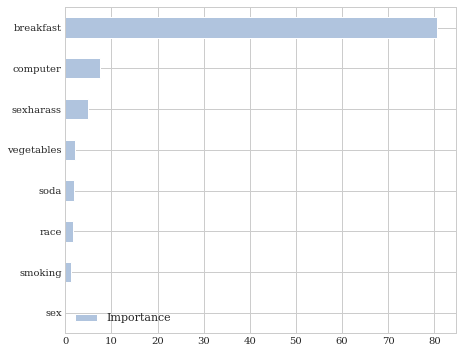

In [106]:
#Getting the importance of features from the best random forest model:
%matplotlib inline 
Importance = pd.DataFrame({'Importance':dtrf_grid_search.best_estimator_.feature_importances_*100}, \
                          index=['sex', 'race', 'sexharass', 'smoking', 'vegetables', 'soda', 'breakfast', 'computer'])
Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='lightsteelblue', )
plt.gcf().set_size_inches(7, 6)

Other named colors like "lightsteelblue" in matplotlib [can be found here](https://matplotlib.org/3.1.0/gallery/color/named_colors.html)

#### Boosting Regression

In [107]:
DTboostsalesreg=GradientBoostingRegressor(random_state=23)

In [108]:
# set the gridsearch parameters for the boosting regression
dtboost_param_grid={'n_estimators': [100, 125, 150], 'max_depth':[3,5,7,10], \
                 'max_leaf_nodes':np.arange(2,10), 'min_samples_split':[5,10,20]}

In [109]:
# define the gridsearch for the boosting model:

dtboost_grid_search = GridSearchCV(DTboostsalesreg, dtboost_param_grid, cv=5, scoring='neg_mean_squared_error')

In [110]:
# Fit the model on training data
# Since we are using the training portion of the data, we are now "training" our model.
dtboost_grid_search.fit(X_train, Y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                                                 n_iter_n...
                            

In [111]:
dtboost_grid_search.cv_results_['mean_test_score']

array([-1.78050922, -1.77824355, -1.77674561, -1.78050922, -1.77824355,
       -1.77674561, -1.78050922, -1.77824355, -1.77674561, -1.76859278,
       -1.76720817, -1.76666431, -1.76859278, -1.76720817, -1.76666431,
       -1.76859278, -1.76720817, -1.76666431, -1.76377144, -1.76330982,
       -1.7633787 , -1.76377144, -1.76330982, -1.7633787 , -1.76377144,
       -1.76330982, -1.7633787 , -1.76346667, -1.76395464, -1.7644181 ,
       -1.76346667, -1.76395464, -1.7644181 , -1.76346667, -1.76395464,
       -1.7644181 , -1.76299129, -1.76298039, -1.76354415, -1.76299129,
       -1.76298039, -1.76354415, -1.76299129, -1.76298039, -1.76354415,
       -1.76365974, -1.764302  , -1.76585989, -1.76365974, -1.764302  ,
       -1.76585989, -1.76365974, -1.764302  , -1.76585989, -1.76452443,
       -1.76564633, -1.76679087, -1.76452443, -1.76564633, -1.76679087,
       -1.76452443, -1.76564633, -1.76679087, -1.76452443, -1.76564633,
       -1.76679087, -1.76452443, -1.76564633, -1.76679087, -1.76

In [112]:
dtboost_grid_search.best_params_

{'max_depth': 5,
 'max_leaf_nodes': 6,
 'min_samples_split': 5,
 'n_estimators': 100}

In [113]:
dtboost_grid_search.best_estimator_

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=5,
                          max_features=None, max_leaf_nodes=6,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=5,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=23, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [114]:
# Get the predicted values and evaluate the bossting model:

DTboost_predictions_tt=dtboost_grid_search.best_estimator_.predict(X_test) # predictions for test set

In [115]:
# How good is this prediction?

np.sqrt(np.square(DTboost_predictions_tt-Y_test).mean()) #RMSE calculation

1.3238181384758354

<Mark>Interpretation:</Mark> Our model is deviant from the actual values by about 1.32 hours per school night, on average when using the test data. 

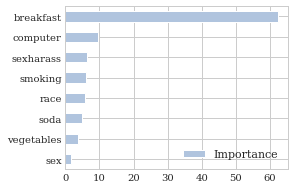

In [117]:
#Getting the importance of features from the best boosting model:
%matplotlib inline 
Importance = pd.DataFrame({'Importance':dtboost_grid_search.best_estimator_.feature_importances_*100}, \
                          index=['sex', 'race', 'sexharass', 'smoking', 'vegetables', 'soda', 'breakfast', 'computer'])
Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='lightsteelblue', )
plt.gcf().set_size_inches(4, 3)

### Classification method

In [37]:
# reading the caravan insurance dataset:
df1 = pd.read_csv('sleeping.csv')

In [38]:
df1.columns

Index(['sleeping', 'sex', 'race', 'sexharass', 'smoking', 'vegetables', 'soda',
       'breakfast', 'computer'],
      dtype='object')

In [39]:
df1['sleepcat']=pd.cut(df1['sleeping'], bins=[0,4,8], labels=['short', 'long']) # 0 = short, 1 =long
df1.head(3)

,sleeping,sex,race,sexharass,smoking,vegetables,soda,breakfast,computer,sleepcat
0,1,2,4,4,4,3,2,3,3,short
1,1,2,3,1,1,2,1,1,2,short
2,1,2,4,1,1,1,1,1,1,short


In [40]:
healthdummy=pd.get_dummies(df1['sleepcat'])
df1['sleepcatlong']=healthdummy['long']
yvar= df1.sleepcatlong.astype('float64')
Xvar = df1.drop(['sleeping', 'sleepcat','sleepcatlong'], axis=1).astype('float64')

In [41]:
# Second, split the data into training and test portions:

X2_train, X2_test, Y2_train, Y2_test = train_test_split(Xvar, yvar, test_size=0.25, random_state=7)
print(X2_train.shape, Y2_train.shape)
print(X2_test.shape, Y2_test.shape)

(27165, 8) (27165,)
(9055, 8) (9055,)


In [47]:
# Select the model approach for fitting: Decision Tree Classifier

DT_insurance = DecisionTreeClassifier(random_state=23)

In [51]:
# set the gridsearch parameters for decision tree
dtc_param_grid={'max_depth':[5, 7, 10], 'max_leaf_nodes':np.arange(2,10), 'max_features': [5, 8, 11]}

In [52]:
# define the gridsearch for decision tree classification:
dtc_grid_search = GridSearchCV(DT_insurance, dtc_param_grid, cv=5, scoring='accuracy')

In [53]:
# Fit the model on training data
# Since we are using the training portion of the data, we are now "training" our model.
dtc_grid_search.fit(X2_train, Y2_train)

C:\Users\edwar\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\Users\edwar\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\Users\edwar\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\Users\edwar\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The

C:\Users\edwar\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\Users\edwar\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\Users\edwar\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\Users\edwar\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The

C:\Users\edwar\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\Users\edwar\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\Users\edwar\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\Users\edwar\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The

C:\Users\edwar\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\Users\edwar\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\Users\edwar\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\Users\edwar\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=23,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': [5, 7, 10], 'max_features': [5, 8, 11],
  

In [54]:
dtc_grid_search.cv_results_['mean_test_score']

array([0.75085588, 0.75085588, 0.75085588, 0.75085588, 0.75085588,
       0.75085588, 0.75085588, 0.75085588, 0.75085588, 0.75085588,
       0.75085588, 0.75085588, 0.75085588, 0.75085588, 0.75085588,
       0.75085588,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan, 0.75085588,
       0.75085588, 0.75085588, 0.75085588, 0.75085588, 0.75085588,
       0.75085588, 0.75085588, 0.75085588, 0.75085588, 0.75085588,
       0.75085588, 0.75085588, 0.75085588, 0.75085588, 0.75085588,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan, 0.75085588, 0.75085588,
       0.75085588, 0.75085588, 0.75085588, 0.75085588, 0.75085588,
       0.75085588, 0.75085588, 0.75085588, 0.75085588, 0.75085588,
       0.75085588, 0.75085588, 0.75085588, 0.75085588,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan])

In [55]:
dtc_grid_search.best_params_

{'max_depth': 5, 'max_features': 5, 'max_leaf_nodes': 2}

In [56]:
dtc_grid_search.best_estimator_

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=5, max_leaf_nodes=2,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=23, splitter='best')

We can visualize the Decision Tree as following:

In [59]:
#get the names of the independent variables for using them in the tree plot
insurance_features=df1.drop(['sleeping', 'sleepcat','sleepcatlong'], axis=1).columns

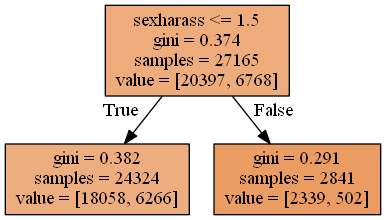

In [60]:
DTcgraph = print_tree(dtc_grid_search.best_estimator_, features=insurance_features)
Image(DTcgraph.create_png())

In [61]:
# Get the predictions of the best decision tree classifier
DT_prediction_ctc=dtc_grid_search.best_estimator_.predict(X2_test)

In [62]:
# Evaluate how good the decision tree classification is:
cm_DTC = confusion_matrix(Y2_test, DT_prediction_ctc)
print("Confusion Matrix:\n", cm_DTC)
print("\n")
print("Classification Report:\n",classification_report(Y2_test, DT_prediction_ctc))

Confusion Matrix:
 [[6835    0]
 [2220    0]]


Classification Report:
               precision    recall  f1-score   support

         0.0       0.75      1.00      0.86      6835
         1.0       0.00      0.00      0.00      2220

    accuracy                           0.75      9055
   macro avg       0.38      0.50      0.43      9055
weighted avg       0.57      0.75      0.65      9055



C:\Users\edwar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


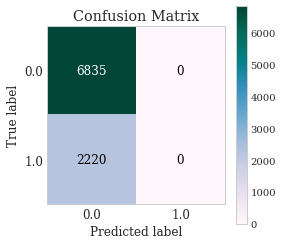

In [64]:
skplt.metrics.plot_confusion_matrix(Y2_test, DT_prediction_ctc, figsize=(4,4), cmap="PuBuGn")

Change colors using the [cmap parameter](https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html)

<Mark>Interpretation:</Mark> We see that the model is just the naive prediction! <br>

In [65]:
1-df1.sleepcatlong.mean()

0.7518498067366096

#### Random Forest Classifier

In [66]:
# Select the model approach for fitting: RandomForest Classifier

DT_insurance_rfc = RandomForestClassifier(random_state=23)

In [67]:
# set the gridsearch parameters for the RandomForest Classifier
dtfc_param_grid={'n_estimators': [10, 15, 20], 'max_depth':[5, 10, 15], \
                 'max_leaf_nodes':np.arange(2,10), 'min_samples_split':[5, 10, 15]}

In [68]:
# define the gridsearch for decision tree classification:
dtrfc_grid_search = GridSearchCV(DT_insurance_rfc, dtfc_param_grid, cv=5, scoring='accuracy')

In [69]:
# Fit the model on training data
# Since we are using the training portion of the data, we are now "training" our model.
dtrfc_grid_search.fit(X2_train, Y2_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=23,
                                  

In [70]:
dtrfc_grid_search.cv_results_['mean_test_score']

array([0.75085588, 0.75085588, 0.75085588, 0.75085588, 0.75085588,
       0.75085588, 0.75085588, 0.75085588, 0.75085588, 0.75085588,
       0.75085588, 0.75085588, 0.75085588, 0.75085588, 0.75085588,
       0.75085588, 0.75085588, 0.75085588, 0.75085588, 0.75085588,
       0.75085588, 0.75085588, 0.75085588, 0.75085588, 0.75085588,
       0.75085588, 0.75085588, 0.75085588, 0.75085588, 0.75085588,
       0.75085588, 0.75085588, 0.75085588, 0.75085588, 0.75085588,
       0.75085588, 0.75085588, 0.75085588, 0.75085588, 0.75085588,
       0.75085588, 0.75085588, 0.75085588, 0.75085588, 0.75085588,
       0.75085588, 0.75085588, 0.75085588, 0.75085588, 0.75085588,
       0.75085588, 0.75085588, 0.75085588, 0.75085588, 0.75085588,
       0.75085588, 0.75085588, 0.75085588, 0.75085588, 0.75085588,
       0.75085588, 0.75085588, 0.75085588, 0.75085588, 0.75085588,
       0.75085588, 0.75085588, 0.75085588, 0.75085588, 0.75085588,
       0.75085588, 0.75085588, 0.75085588, 0.75085588, 0.75085

In [71]:
dtrfc_grid_search.best_params_

{'max_depth': 5,
 'max_leaf_nodes': 2,
 'min_samples_split': 5,
 'n_estimators': 10}

In [72]:
dtrfc_grid_search.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=2, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=23, verbose=0,
                       warm_start=False)

In [73]:
# Get the predictions of the best Random Forest classifier
DTrfc_prediction_ctc=dtrfc_grid_search.best_estimator_.predict(X2_test)

In [74]:
# Evaluate how good the Random Forest classification is:
cm_DTC = confusion_matrix(Y2_test, DTrfc_prediction_ctc)
print("Confusion Matrix:\n", cm_DTC)
print("\n")
print("Classification Report:\n",classification_report(Y2_test, DTrfc_prediction_ctc))

Confusion Matrix:
 [[6835    0]
 [2220    0]]


Classification Report:
               precision    recall  f1-score   support

         0.0       0.75      1.00      0.86      6835
         1.0       0.00      0.00      0.00      2220

    accuracy                           0.75      9055
   macro avg       0.38      0.50      0.43      9055
weighted avg       0.57      0.75      0.65      9055



C:\Users\edwar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


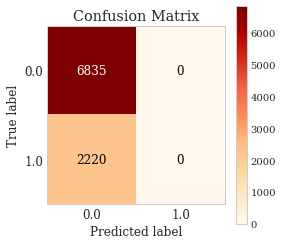

In [76]:
skplt.metrics.plot_confusion_matrix(Y2_test, DTrfc_prediction_ctc, figsize=(4,4), cmap="OrRd")

<Mark>Interpretation:</Mark> We see that the model is exactly similar to a naive prediction! <br>

Another useful feature of ensembles is that we can derive the importance of different variables in infleuncing the prediction. 

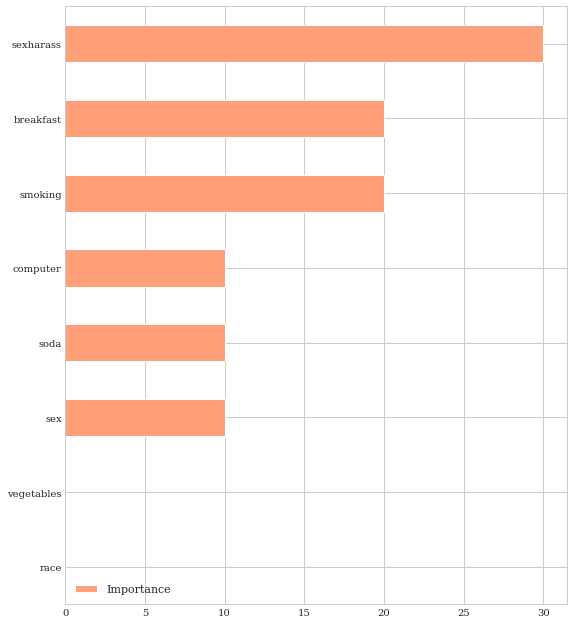

In [78]:
%matplotlib inline
Importance = pd.DataFrame({'Importance':dtrfc_grid_search.best_estimator_.feature_importances_*100}, \
                          index=insurance_features)
Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='lightsalmon', )
plt.gcf().set_size_inches(9, 11)

#### Boosting Classifier

In [79]:
# Select the model approach for fitting: Gradiant Boosting Classifier

DT_insurance_bc = GradientBoostingClassifier(random_state=23)

In [80]:
# set the gridsearch parameters for the Gradiant Boosting Classifier
dtbc_param_grid={'n_estimators': [100, 125, 150], 'max_depth':[3,5,7,10], \
                 'max_leaf_nodes':np.arange(2,10), 'min_samples_split':[5,10,20]}

In [81]:
# define the gridsearch for Gradiant Boosting classification:
dtbc_grid_search = GridSearchCV(DT_insurance_bc, dtfc_param_grid, cv=5, scoring='accuracy')

In [82]:
# Fit the model on training data
# Since we are using the training portion of the data, we are now "training" our model.
# Be patient -- it might take while to finish!

dtbc_grid_search.fit(X2_train, Y2_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_c...
                 

In [83]:
dtbc_grid_search.cv_results_['mean_test_score']

array([0.75085588, 0.75085588, 0.75085588, 0.75085588, 0.75085588,
       0.75085588, 0.75085588, 0.75085588, 0.75085588, 0.75085588,
       0.75085588, 0.75085588, 0.75085588, 0.75085588, 0.75085588,
       0.75085588, 0.75085588, 0.75085588, 0.75085588, 0.75085588,
       0.75085588, 0.75085588, 0.75085588, 0.75085588, 0.75085588,
       0.75085588, 0.75085588, 0.75085588, 0.75085588, 0.75085588,
       0.75085588, 0.75085588, 0.75085588, 0.75085588, 0.75085588,
       0.75085588, 0.75085588, 0.75085588, 0.75085588, 0.75085588,
       0.75085588, 0.75085588, 0.75085588, 0.75085588, 0.75085588,
       0.75085588, 0.75085588, 0.75085588, 0.75085588, 0.75085588,
       0.75085588, 0.75085588, 0.75085588, 0.75085588, 0.75085588,
       0.75085588, 0.75085588, 0.75085588, 0.75085588, 0.75085588,
       0.75085588, 0.75085588, 0.75085588, 0.75085588, 0.75085588,
       0.75085588, 0.75085588, 0.75085588, 0.75085588, 0.75085588,
       0.75085588, 0.75085588, 0.75085588, 0.75085588, 0.75085

In [84]:
dtbc_grid_search.best_params_

{'max_depth': 5,
 'max_leaf_nodes': 2,
 'min_samples_split': 5,
 'n_estimators': 10}

In [85]:
dtbc_grid_search.best_estimator_

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=5,
                           max_features=None, max_leaf_nodes=2,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=5,
                           min_weight_fraction_leaf=0.0, n_estimators=10,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=23, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [86]:
# Get the predictions of the best boosting classifier
DTbc_prediction_ctc=dtbc_grid_search.best_estimator_.predict(X2_test)

In [87]:
# Evaluate how good the boosting classification is:
cm_DTC = confusion_matrix(Y2_test, DTbc_prediction_ctc)
print("Confusion Matrix:\n", cm_DTC)
print("\n")
print("Classification Report:\n",classification_report(Y2_test, DTbc_prediction_ctc))

Confusion Matrix:
 [[6835    0]
 [2220    0]]


Classification Report:
               precision    recall  f1-score   support

         0.0       0.75      1.00      0.86      6835
         1.0       0.00      0.00      0.00      2220

    accuracy                           0.75      9055
   macro avg       0.38      0.50      0.43      9055
weighted avg       0.57      0.75      0.65      9055



C:\Users\edwar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


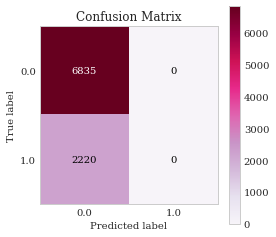

In [93]:
skplt.metrics.plot_confusion_matrix(Y2_test, DTbc_prediction_ctc, figsize=(4,4), cmap="PuRd")

<Mark>Interpretation:</Mark> We see that the model is exactly similar to a naive prediction! <br>

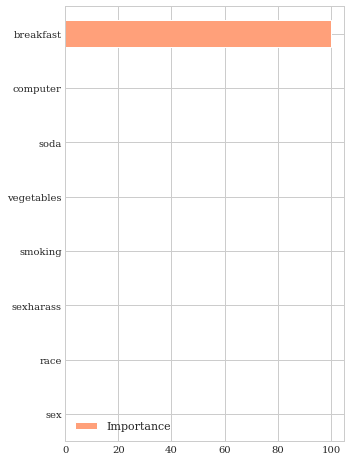

In [95]:
%matplotlib inline 
Importance = pd.DataFrame({'Importance':dtbc_grid_search.best_estimator_.feature_importances_*100}, \
                          index=insurance_features)
Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='lightsalmon', )
plt.gcf().set_size_inches(5, 8)
plt.show()

***
<Mark>Navigation:</Mark><br>
* [Topic 1: Tuning linear regression prediction model](#section_id1)<br>
* [Topic 2: Tuning logistic regression prediction model](#section_id2)<br>
* [Topic 3: Tuning KNN prediction model](#section_id3)<br>
* [Topic 4: Tuning tree-based prediction models](#section_id4)<br>
***

***
<center>
All done!It Has Been Such A Wonderful Journey With You​!
</center>

<div style="text-align: right"> <a href='#section_id0'>Back to top of Notebook</a></div>